In [1]:
%%capture
!pip3 install pykalman
!pip3 install ffn

In [5]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from scipy import stats
import datetime as dt
import pandas as pd
import math
import os.path
import time
import json
import requests
from datetime import timedelta, datetime
from dateutil import parser
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import warnings
import ffn
import pandas_datareader.data as web
import requests
import yfinance as yf

In [6]:
symbols = [
            'ARW', 'JBL', 'PLXS', 'TEL', 'EMR', 'COHR', # Electronics industry
            'AMD', 'TER', 'NVMI', 'KLAC', 'VIAV', 'TDY', # Semiconductor industry
            'BAX', 'BKD', 'ADUS', 'SNDA', 'CHE', # Healthcare
            'SPY'
          ]

In [7]:
color_palette = {'white': '#fbfffd', 'gray': '#3F3F3F', 'lightgrey': '#D3D3D3', 'sand': '#EEECE1', 'navy': '#264C6E', 'blue': '#558ED5', 'sky': '#8FAADD', 'arctic': '#AFCEEB', 'red': '#C55A0F'}

In [8]:
risk_free_rate_annual = 0.04
risk_free_rate_daily = risk_free_rate_annual / 252

In [9]:
from google.colab import files
import matplotlib.font_manager as fm

uploaded = files.upload()

# Assume the font file is named 'Ubuntu.ttf'
font_file_name = next(iter(uploaded))

# Load the uploaded font file
font_path = './' + font_file_name  # Adjust the path if necessary
garamond_font_prop = fm.FontProperties(fname=font_path)

# Add the font to Matplotlib's font manager
fm.fontManager.addfont(font_path)
fm.FontProperties(fname=font_path)  # Load the font properties

# Update the default font to Garamond
plt.rcParams.update({'font.family':'Ubuntu'})

Saving Ubuntu-Medium.ttf to Ubuntu-Medium.ttf


In [10]:
def get_stock_data(tickers, start_date, end_date):
    # Create an empty DataFrame to store stock data
    stock_data = pd.DataFrame()

    # Loop through each ticker and fetch the historical data
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)

        # If the DataFrame is empty, initialize it with data
        if stock_data.empty:
            stock_data = data[['Close']].copy()
            stock_data.columns = [ticker]
        else:
            # If the DataFrame already exists, just join the new data
            stock_data = stock_data.join(data['Close'].to_frame(ticker))

    return stock_data

In [11]:
start = pd.Timestamp('2016-02-15')
end = pd.Timestamp('2024-02-17')

prices = get_stock_data(tickers=symbols, start_date=start, end_date=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [12]:
combo = prices.copy()
combo.index = pd.DatetimeIndex(combo.index)

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
combo.head()

,ARW,JBL,PLXS,TEL,EMR,COHR,AMD,TER,NVMI,KLAC,VIAV,TDY,BAX,BKD,ADUS,SNDA,CHE,SPY
Date,,,,,,,,,,,,,,,,,,
2016-02-16,55.689999,20.309999,35.889999,55.500000,46.619999,20.150000,1.83,18.230000,9.51,64.739998,6.05,81.639999,37.410000,12.28,23.070000,224.850006,134.000000,189.779999
2016-02-17,56.130001,20.240000,36.340000,56.740002,47.759998,20.379999,1.90,18.719999,9.73,65.570000,6.11,82.360001,38.209999,13.65,23.459999,231.600006,135.000000,192.880005
2016-02-18,57.189999,20.520000,36.549999,57.180000,48.340000,20.469999,1.91,18.790001,9.96,64.849998,6.34,82.190002,38.070000,13.81,22.620001,231.000000,126.480003,192.089996
2016-02-19,56.959999,20.700001,36.500000,57.610001,48.060001,21.139999,1.91,18.830000,9.95,65.690002,6.29,82.650002,37.650002,13.58,21.540001,231.149994,126.570000,192.000000
2016-02-22,57.099998,21.000000,35.950001,58.180000,49.279999,20.980000,2.01,18.879999,10.36,66.139999,6.38,83.599998,38.410000,13.95,22.309999,243.000000,128.639999,194.779999


In [13]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2016-02-16 to 2024-02-16
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARW     2016 non-null   float64
 1   JBL     2016 non-null   float64
 2   PLXS    2016 non-null   float64
 3   TEL     2016 non-null   float64
 4   EMR     2016 non-null   float64
 5   COHR    2016 non-null   float64
 6   AMD     2016 non-null   float64
 7   TER     2016 non-null   float64
 8   NVMI    2016 non-null   float64
 9   KLAC    2016 non-null   float64
 10  VIAV    2016 non-null   float64
 11  TDY     2016 non-null   float64
 12  BAX     2016 non-null   float64
 13  BKD     2016 non-null   float64
 14  ADUS    2016 non-null   float64
 15  SNDA    2016 non-null   float64
 16  CHE     2016 non-null   float64
 17  SPY     2016 non-null   float64
dtypes: float64(18)
memory usage: 299.2 KB


In [14]:
num_stocks = len(combo.columns)
print('Number of Stocks =', num_stocks)

Number of Stocks = 18


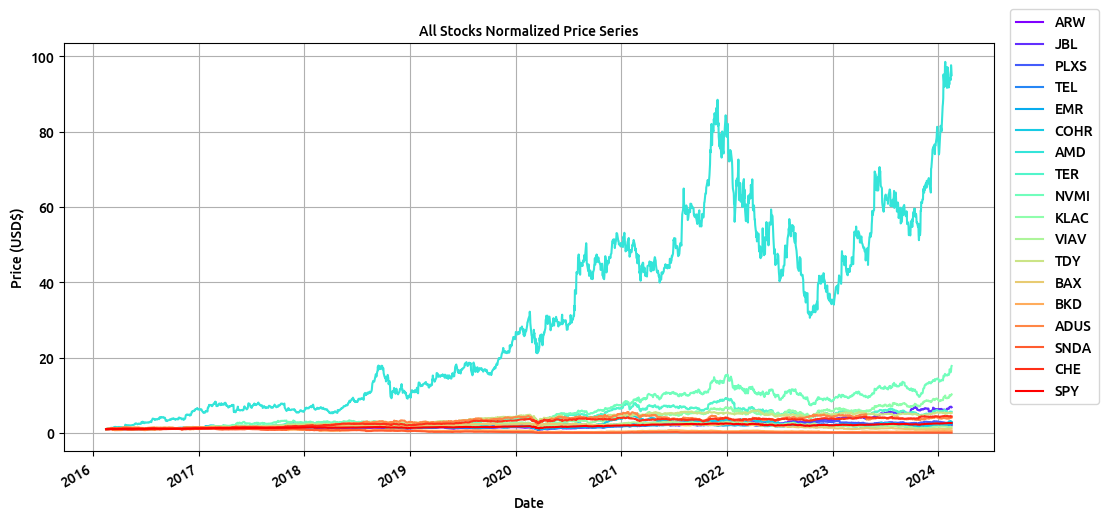

In [15]:
n_secs = len(combo.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
combo.div(combo.iloc[0,:]).plot(color=colors, figsize=(12, 6)) # Normalize Prices
plt.title('All Stocks Normalized Price Series', fontproperties=garamond_font_prop)
plt.xlabel('Date')
plt.ylabel('Price (USD$)')
plt.grid(which='major', axis='both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

# Set up Cointegration Tests

In [16]:
# Critical level = 5%
def find_cointegrated_pairs_adfuller(dataframe, critical_level = 0.05):
    n = dataframe.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = dataframe.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]] # obtain the price of "stock2"

            # Run linear regression on the time series
            stock1 = sm.add_constant(stock1) # Add a constant term to the independent variable
            result = sm.OLS(stock2, stock1).fit() # Ordinary Least Squares regression
            residual = result.resid # Get the residuals of the regression

            # Augmented Dickey-Fuller test for cointegration
            adf_test = sm.tsa.stattools.adfuller(residual)
            pvalue = adf_test[1]

            pvalue_matrix[i, j] = pvalue
            if pvalue < critical_level and keys[i]!='SPY' and keys[j]!='SPY': # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue))                      # record the pair with that p-value
    return pvalue_matrix, pairs

In [17]:
df = combo

binance_symbols = df.columns

# set up train/test split
split = int(len(df) * 0.75)

# run cointegration test
pvalue_matrix, pairs = find_cointegrated_pairs_adfuller(df[:split])

# convert cointegration test results into dataframe
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

# Graph Results of Cointegration Tests

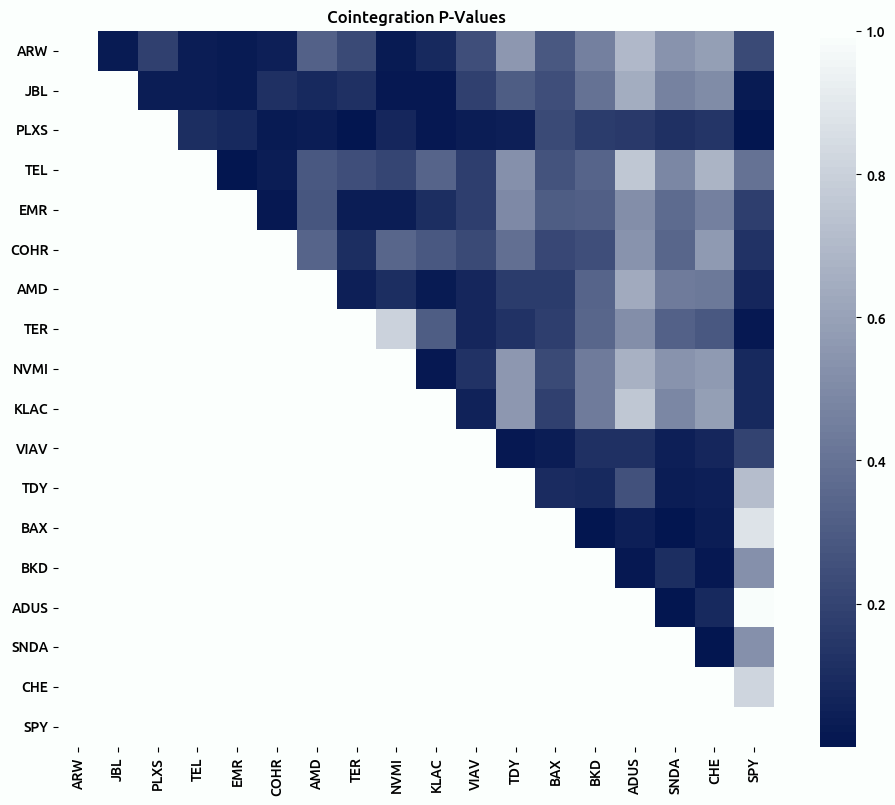

In [18]:
import matplotlib.colors as mcolors

hex_color1 = '#031650'
hex_color2 = color_palette['white']

plt.figure(figsize=(10, 8))

# create color map gradient from hex_color1 to hex_color2
colors = [hex_color1, hex_color2]
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=n_bins)

# create heatmap of cointegrations
mask = np.tril(pvalue_matrix_df.corr())
ax = sns.heatmap(pvalue_matrix_df, xticklabels=binance_symbols, yticklabels=binance_symbols, square=True, linecolor=color_palette['white'], linewidths=0, cmap=cmap)

ax.set_facecolor('black')
plt.gcf().set_facecolor(color_palette['white']) # background color

plt.tight_layout()
plt.title('Cointegration P-Values', fontweight='bold')
plt.show()

In [19]:
for pair in pairs:
    print("Asset {} and Asset {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

# Pairs w/in same industry that we settled on
# Doing this to avoid cross-industry pairs
pairs = [['AMD', 'TER'], ['NVMI', 'KLAC'], ['VIAV', 'TDY'],
         ['ARW', 'EMR'], ['JBL', 'PLXS'], ['TEL', 'COHR'], ['TEL', 'EMR'], ['PLXS', 'COHR'],
         ['BKD', 'BAX'], ['BKD', 'ADUS'], ['SNDA', 'CHE'], ['ADUS', 'SNDA'], ['BAX', 'SNDA']]

Asset ARW and Asset JBL has a co-integration score of 0.0261
Asset ARW and Asset TEL has a co-integration score of 0.0304
Asset ARW and Asset EMR has a co-integration score of 0.0297
Asset ARW and Asset COHR has a co-integration score of 0.0488
Asset ARW and Asset NVMI has a co-integration score of 0.0241
Asset JBL and Asset PLXS has a co-integration score of 0.0369
Asset JBL and Asset TEL has a co-integration score of 0.0366
Asset JBL and Asset EMR has a co-integration score of 0.0258
Asset JBL and Asset NVMI has a co-integration score of 0.0112
Asset JBL and Asset KLAC has a co-integration score of 0.0122
Asset PLXS and Asset COHR has a co-integration score of 0.0221
Asset PLXS and Asset AMD has a co-integration score of 0.0342
Asset PLXS and Asset TER has a co-integration score of 0.0011
Asset PLXS and Asset KLAC has a co-integration score of 0.013
Asset PLXS and Asset VIAV has a co-integration score of 0.0353
Asset PLXS and Asset TDY has a co-integration score of 0.0405
Asset TEL a

# Set up Kalman Filters

In [20]:
# Construct a Kalman filter for time series
def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1], # random walk --> next phase is same as previous plus process noise (transition covariance)
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    # Use observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    """
    This function estimates the time it takes for a time series to revert halfway to its long-term mean value,
    assuming it follows a mean-reverting process.

    Half-life is calculated based on the coefficient from a simple linear regression of the
    series on its one-period lagged values.
    """

    # Shift the spread to create a lagged spread series
    spread_lag = spread.shift(1)
    # Replace the first NaN value that results from shifting the series
    spread_lag.iloc[0] = spread_lag.iloc[1]

    # Calculate the difference between the spread and the lagged spread
    # This represents the period-to-period change in the spread
    spread_ret = spread - spread_lag
    # Replace the first NaN value that results from the difference calculation
    spread_ret.iloc[0] = spread_ret.iloc[1]

    # Add a constant term to the lagged spread for the OLS regression
    # The constant term allows for an intercept in the regression equation
    spread_lag2 = sm.add_constant(spread_lag)

    # Set up and fit the OLS regression model
    # The dependent variable is the spread return
    # The independent variables are the lagged spread and the constant term
    model = sm.OLS(spread_ret, spread_lag2)
    res = model.fit()

    # Calculate the half-life of mean reversion based on the fitted coefficient
    # The formula is based on the Ornstein-Uhlenbeck process for mean reversion
    # A negative coefficient indicates mean reversion, and its magnitude
    # determines the speed of reversion
    halflife = int(round(-np.log(2) / res.params[1], 0))

    # Ensure the half-life is at least 1 period to avoid nonsensical negative values
    # Negative or zero half-life would imply no mean reversion, which is not possible in this context
    if halflife <= 0:
        halflife = 1

    # Return the calculated half-life
    return halflife

# Backtesting Logic

In [21]:
def backtest(df, s1, s2, split):
    #############################################################
    # INPUT:
    # DataFrame of prices (df)
    # s1: the symbol of asset one
    # s2: the symbol of asset two
    # x: the price series of asset one
    # y: the price series of asset two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    #############################################################
    # TRAINING #
    #############################################################
    df_train = df[:split]
    df_test = df[split:]

    x = df_train[s1]
    y = df_train[s2]

    # Run regression (including Kalman Filter) to find hedge ratio
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]

    # Then create spread series
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    # Ranges for grid search
    entryZscoreRange = np.arange(0.25, 2.0, 0.125)
    exitZscoreRange = np.arange(-1.5, 0.5, 0.125)

    best_sharpe = -np.inf
    best_params = {}

    for entryZscore in entryZscoreRange:
        for exitZscore in exitZscoreRange:
            # Num units long
            df1['long entry'] = ((df1.zScore < - entryZscore) & (df1.zScore.shift(1) > - entryZscore))
            df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
            df1['num units long'] = np.nan
            df1.loc[df1['long entry'],'num units long'] = 1
            df1.loc[df1['long exit'],'num units long'] = 0
            df1['num units long'][0] = 0
            df1['num units long'] = df1['num units long'].fillna(method='pad')

            # Num units short
            df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
            df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
            df1.loc[df1['short entry'],'num units short'] = -1
            df1.loc[df1['short exit'],'num units short'] = 0
            df1['num units short'][0] = 0
            df1['num units short'] = df1['num units short'].fillna(method='pad')

            # Set up totals: num units and returns
            df1['numUnits'] = df1['num units long'] + df1['num units short']
            df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
            df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
            df1['cum rets'] = df1['port rets'].cumsum()
            df1['cum rets'] = df1['cum rets'] + 1

            current_sharpe = 0.0

            try:
                current_sharpe = (((df1['port rets'].mean() - risk_free_rate_daily) / df1['port rets'].std()) * sqrt(252))
            except ZeroDivisionError:
                current_sharpe = 0.0

            # Update best parameters if current Sharpe ratio is better
            if current_sharpe > best_sharpe:
                best_sharpe = current_sharpe
                best_params = {'entryZscore': entryZscore, 'exitZscore': exitZscore, 'sharpe': best_sharpe}

    print(f"Best Parameters: Entry Z-Score = {best_params['entryZscore']}, Exit Z-Score = {best_params['exitZscore']}, Sharpe Ratio = {best_params['sharpe']}")

    #############################################################
    # TESTING #
    #############################################################

    # After the grid search, use best_params to run the strategy one more time or just report the best parameters

    x = df_test[s1]
    y = df_test[s2]

    # Run regression (including Kalman Filter) to find hedge ratio
    # Ensures that strategy is market neutral
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]

    # Then create spread series
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    entryZscore = best_params['entryZscore']
    exitZscore = best_params['exitZscore']

    # Num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & (df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Num units short
    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    # Set up totals: num units and returns
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################

    try:
        test_sharpe = (((df1['port rets'].mean() - risk_free_rate_daily) / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        test_sharpe = 0.0

    ##############################################################

    # Calculate number of trades
    total_trades = df1['long entry'].sum() + df1['short entry'].sum() + df1['long exit'].sum() + df1['short exit'].sum()

    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1

    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']

    return df1[s1+ " "+s2+'_cum_rets'], best_params['sharpe'], test_sharpe, CAGR, entryZscore, exitZscore, total_trades

# Run backtest and store results

In [22]:
results = []
train_sharpes = []
test_sharpes = []
entryZscores = []
exitZscores = []
total_trades_list = []

for pair in pairs:
    rets, train_sharpe, test_sharpe, CAGR, entryZscore, exitZscore, total_trades = backtest(df, pair[0], pair[1], split)
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],
                                                                                     round(test_sharpe,2),
                                                                                     round(CAGR,4)))

    rets0 = pd.concat(results, axis=1)
    train_sharpes.append(train_sharpe)
    test_sharpes.append(test_sharpe)
    entryZscores.append(entryZscore)
    exitZscores.append(exitZscore)
    total_trades_list.append(total_trades)

Best Parameters: Entry Z-Score = 1.875, Exit Z-Score = -1.5, Sharpe Ratio = 0.6608921823527935
The pair AMD and TER produced a Sharpe Ratio of 0.9 and a CAGR of 0.0972
Best Parameters: Entry Z-Score = 1.375, Exit Z-Score = -1.125, Sharpe Ratio = 1.2040389175188195
The pair NVMI and KLAC produced a Sharpe Ratio of 1.11 and a CAGR of 0.0991
Best Parameters: Entry Z-Score = 0.25, Exit Z-Score = -1.25, Sharpe Ratio = 0.025668525003561166
The pair VIAV and TDY produced a Sharpe Ratio of -0.74 and a CAGR of -0.054
Best Parameters: Entry Z-Score = 1.5, Exit Z-Score = -0.75, Sharpe Ratio = 1.2115511419285216
The pair ARW and EMR produced a Sharpe Ratio of 0.26 and a CAGR of 0.0444
Best Parameters: Entry Z-Score = 1.5, Exit Z-Score = -1.5, Sharpe Ratio = 1.2973619162599412
The pair JBL and PLXS produced a Sharpe Ratio of 1.2 and a CAGR of 0.1233
Best Parameters: Entry Z-Score = 1.5, Exit Z-Score = -1.375, Sharpe Ratio = 0.8585466657737022
The pair TEL and COHR produced a Sharpe Ratio of 1.37 an

# Analysis of Backtest Results

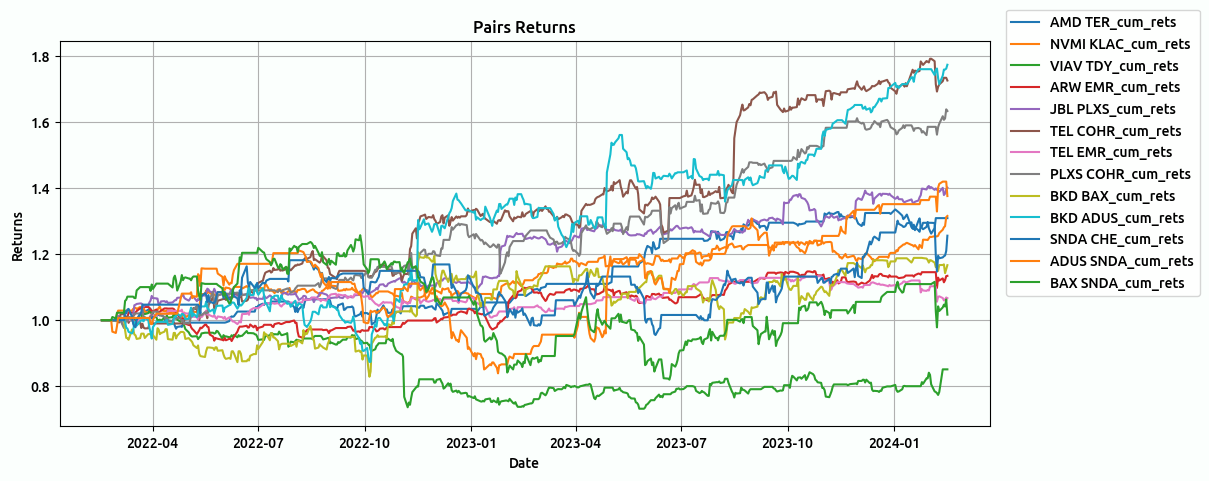

In [23]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor=color_palette['white'])
ax.set_facecolor(color_palette['white'])
plt.plot(rets0)
plt.legend(rets0, bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.grid(which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns');

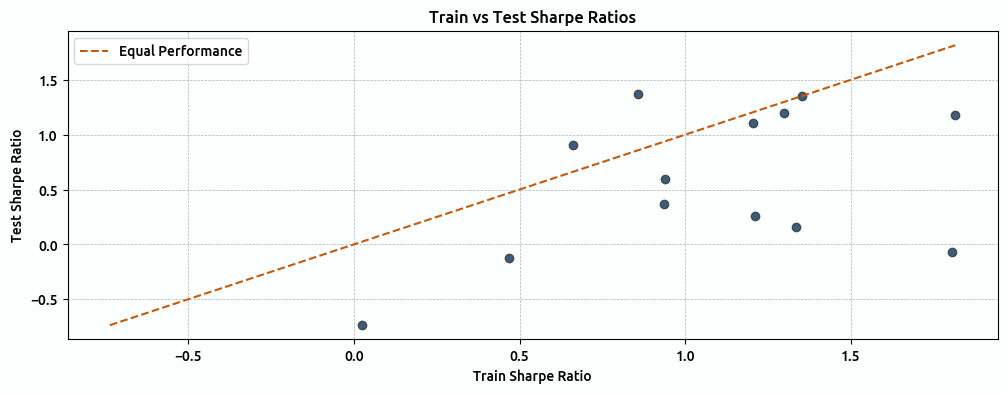

In [24]:
fig, ax = plt.subplots(figsize=(12, 4), facecolor=color_palette['white'])
ax.set_facecolor(color_palette['white'])
plt.scatter(train_sharpes, test_sharpes, color=color_palette['navy'], edgecolor=color_palette['gray'], alpha=0.9)
plt.title('Train vs Test Sharpe Ratios')
plt.xlabel('Train Sharpe Ratio')
plt.ylabel('Test Sharpe Ratio')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#Add a line representing where train_sharpe equals test_sharpe
plt.plot([min(train_sharpes + test_sharpes), max(train_sharpes + test_sharpes)],
          [min(train_sharpes + test_sharpes), max(train_sharpes + test_sharpes)],
          color=color_palette['red'], linestyle='--', label='Equal Performance')
plt.legend()

plt.show()

In [25]:
filename = 'pairs_rets.csv'
rets0.to_csv(filename)

In [26]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

Bin Count = 22.427661492005804


In [27]:
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

In [28]:
# set SPY as benchmark
bench = df.loc[str(Pair_Rets.index[0]):str(Pair_Rets.index[-1])].SPY.pct_change().dropna()
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

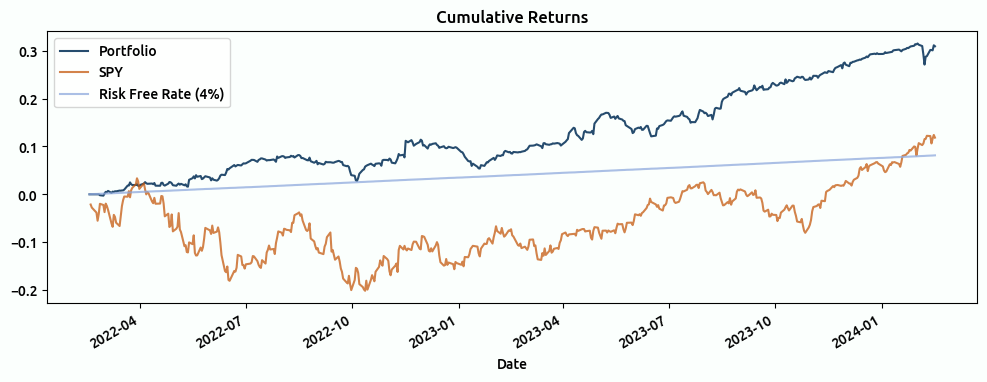

In [29]:
Pair_Rets['Pairs_Returns'].index = pd.to_datetime(Pair_Rets['Pairs_Returns'].index)
bench.index = pd.to_datetime(bench.index)

# Set up RFR
risk_free_rate_annual = 0.04
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1
dates = Pair_Rets['Pairs_Returns'].index
risk_free_returns_daily = pd.Series(risk_free_rate_daily, index=dates)

# Calculate cumulative returns for strategy, benchmark, and risk-free rate
cumulative_returns_strategy = (1 + Pair_Rets['Pairs_Returns']).cumprod() - 1
cumulative_returns_benchmark = (1 + bench).cumprod() - 1
cumulative_returns_risk_free = (1 + risk_free_returns_daily).cumprod() - 1

# Plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 4), facecolor=color_palette['white'])
ax.set_facecolor(color_palette['white'])
cumulative_returns_strategy.plot(label='Portfolio', color=color_palette['navy'])
cumulative_returns_benchmark.plot(label='SPY', alpha=0.75, color=color_palette['red'])
cumulative_returns_risk_free.plot(label='Risk Free Rate (4%)', alpha=0.75, color=color_palette['sky'])
plt.title("Cumulative Returns")
plt.legend()
plt.show()

### Number of trades per pair

In [35]:
print("Number of trades per pair:", total_trades_list)

Number of trades per pair: [94, 194, 129, 153, 166, 155, 170, 149, 200, 185, 102, 192, 198]


# Display Summary Statistics

In [31]:
perf = final_res.calc_stats()

perf.display()

Stats for None from 2022-02-16 00:00:00 - 2024-02-16 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
30.94%              2.08  14.44%  -5.42%

Annualized Returns:
mtd     3m     6m     ytd    1y      3y      5y    10y    incep.
------  -----  -----  -----  ------  ------  ----  -----  --------
-0.30%  4.12%  9.74%  1.25%  20.68%  14.44%  -     -      14.44%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.08     2.14       0.81
mean    13.75%   13.90%     9.55%
vol     6.61%    6.50%      11.73%
skew    1.06     -0.40      -
kurt    8.12     -0.36      -
best    3.22%    4.19%      17.84%
worst   -1.65%   -2.79%     1.25%

Drawdowns:
max     avg       # days
------  ------  --------
-5.42%  -0.78%     10.96

Misc:
---------------  -------
avg. up month    2.02%
avg. down month  -1.44%
up year %        100.00%
12m up %         100.00%
----